In [1]:
install.packages("tidyverse")
install.packages("rstatix")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# Load libraries
library(tidyverse)
library(rstatix)

# Load data
glucose_data <- read.csv("glucose_rm.csv")

# Reshape to long format
glucose_long <- glucose_data %>%
  pivot_longer(cols = Glucose_Week0:Glucose_Week8,
               names_to = "Time",
               names_prefix = "Glucose_",
               values_to = "Glucose") %>%
  mutate(Subject_ID = factor(Subject_ID),
         Time = factor(Time, levels = c("Week0", "Week2", "Week4", "Week8")))

# View structure
head(glucose_long, 8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




Subject_ID,Age,Sex,BMI,Time,Glucose
<fct>,<int>,<chr>,<dbl>,<fct>,<dbl>
P001,46,Female,39.7,Week0,151.2
P001,46,Female,39.7,Week2,133.0
P001,46,Female,39.7,Week4,123.4
P001,46,Female,39.7,Week8,122.9
P002,39,Female,30.2,Week0,129.5
P002,39,Female,30.2,Week2,144.2
P002,39,Female,30.2,Week4,118.2
P002,39,Female,30.2,Week8,97.7


In [3]:
rm_anova <- anova_test(
  data = glucose_long,
  dv = Glucose,
  wid = Subject_ID,
  within = Time,
  effect.size = "pes"
)

rm_anova

ANOVA Table (type III tests)

$ANOVA
  Effect DFn DFd      F        p p<.05   pes
1   Time   3  69 54.191 4.08e-18     * 0.702

$`Mauchly's Test for Sphericity`
  Effect     W     p p<.05
1   Time 0.463 0.005     *

$`Sphericity Corrections`
  Effect   GGe      DF[GG]    p[GG] p[GG]<.05   HFe      DF[HF]    p[HF]
1   Time 0.718 2.15, 49.53 1.23e-13         * 0.794 2.38, 54.82 7.46e-15
  p[HF]<.05
1         *

In [4]:
# Part B: Report F-statistic, degrees of freedom, p-value, and partial eta-squared
# (Uncorrected values)
rm_anova$ANOVA

Effect,DFn,DFd,F,p,p<.05,pes
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Time,3,69,54.191,4.08e-18,*,0.702


In [6]:
# Part C: Apply Greenhouse-Geisser correction (since Mauchly's p = 0.005 < 0.05)
get_anova_table(rm_anova, correction = "GG")

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Time,2.15,49.53,54.191,1.23e-13,*,0.702


In [7]:
# Part D: Interpretation
glucose_long %>%
  group_by(Time) %>%
  summarise(Mean = mean(Glucose), SD = sd(Glucose))

Time,Mean,SD
<fct>,<dbl>,<dbl>
Week0,139.6667,24.99742
Week2,122.5708,23.48899
Week4,111.4083,26.20382
Week8,102.8167,23.61850


A one-way repeated measures ANOVA showed a significant effect of Time on fasting blood glucose, F(3, 69) = 54.19, p < .001, ηp² = 0.702. Mauchly's test indicated sphericity was violated (W = 0.463, p = 0.005), so Greenhouse-Geisser corrected results are reported: F(2.15, 49.53) = 54.19, p < .001. Mean glucose decreased from 139.67 mg/dL at baseline to 102.82 mg/dL at Week 8, a reduction of ~37 mg/dL. This indicates GlucoReg-X significantly reduces fasting blood glucose over the 8-week treatment period. The large effect size (ηp² = 0.70) suggests clinically meaningful improvement.

# QUESTION 2 - TASK 1

In [3]:
# Install required packages
install.packages("rvest")
install.packages("httr")
install.packages("dplyr")

Installing package into ‘/home/jupyter-lapula/R/x86_64-pc-linux-gnu-library/4.5’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter-lapula/R/x86_64-pc-linux-gnu-library/4.5’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter-lapula/R/x86_64-pc-linux-gnu-library/4.5’
(as ‘lib’ is unspecified)

Warning message in install.packages("dplyr"):
“installation of package ‘dplyr’ had non-zero exit status”


Task 1: Web Scraping Code

In [4]:
library(rvest)
library(httr)

user_agent <- "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"
base_url <- "https://old.reddit.com/r/AskDocs/"

cat("TASK 1: WEB SCRAPING WITH RVEST\n\n")
cat("Connecting to r/AskDocs subreddit...\n\n")

page <- read_html(GET(base_url, user_agent(user_agent)))

post_titles <- page %>%
  html_nodes("a.title") %>%
  html_text()

post_urls <- page %>%
  html_nodes("a.title") %>%
  html_attr("href")

post_urls <- ifelse(grepl("^/r/", post_urls), paste0("https://old.reddit.com", post_urls), post_urls)

valid_posts <- !is.na(post_titles) & !is.na(post_urls)
post_titles <- post_titles[valid_posts]
post_urls <- post_urls[valid_posts]

post_titles <- post_titles[2:6]
post_urls <- post_urls[2:6]

cat("Successfully identified the first 5 posts (excluding pinned thread):\n\n")
for (i in 1:length(post_titles)) {
  cat(sprintf("Post %d: %s\n", i, post_titles[i]))
  cat(sprintf("URL: %s\n\n", post_urls[i]))
}

cat("------------------------------------------------------\n\n")
cat("Now scraping each post for comments...\n\n")

all_post_titles <- c()
all_post_urls <- c()
all_post_bodies <- c()
all_comments <- list()

for (i in 1:length(post_urls)) {
  cat(sprintf("------------------------------------------------------\n"))
  cat(sprintf("SCRAPING POST %d of 5\n", i))
  cat(sprintf("------------------------------------------------------\n"))
  cat(sprintf("Title: %s\n\n", post_titles[i]))

  Sys.sleep(2)

  tryCatch({
    post_page <- read_html(GET(post_urls[i], user_agent(user_agent)))

    all_text <- post_page %>%
      html_nodes("form.usertext div.md") %>%
      html_text() %>%
      trimws()

    if (length(all_text) > 1) {
      all_text <- all_text[-1]
    }

    post_body <- ""
    comments <- character(0)

    if (length(all_text) > 0) {
      post_body <- all_text[1]
    }

    if (length(all_text) > 1) {
      comments <- all_text[2:length(all_text)]
    }

    cat("POST BODY:\n")
    cat(post_body)
    cat("\n\n")

    cat(sprintf("TOTAL COMMENTS: %d\n\n", length(comments)))

    if (length(comments) > 0) {
      for (j in 1:length(comments)) {
        cat(sprintf("--- Comment %d ---\n", j))
        cat(comments[j])
        cat("\n\n")
      }
    } else {
      cat("No comments found for this post.\n\n")
    }

    all_post_titles <- c(all_post_titles, post_titles[i])
    all_post_urls <- c(all_post_urls, post_urls[i])
    all_post_bodies <- c(all_post_bodies, post_body)
    all_comments[[i]] <- comments

  }, error = function(e) {
    cat(sprintf("ERROR: %s\n\n", e$message))
    all_post_titles <- c(all_post_titles, post_titles[i])
    all_post_urls <- c(all_post_urls, post_urls[i])
    all_post_bodies <- c(all_post_bodies, "")
    all_comments[[i]] <- character(0)
  })
}

cat("\n")
cat("======================================================\n")
cat("SCRAPING COMPLETE - FINAL SUMMARY\n")
cat("======================================================\n\n")

total_comments <- sum(sapply(all_comments, length))
cat(sprintf("Total posts scraped: %d\n", length(all_post_titles)))
cat(sprintf("Total comments collected: %d\n\n", total_comments))

cat("Breakdown by post:\n\n")
for (i in 1:length(all_post_titles)) {
  cat(sprintf("Post %d: %s\n", i, all_post_titles[i]))
  cat(sprintf("  Comments: %d\n\n", length(all_comments[[i]])))
}

cat("Data stored in: all_post_titles, all_post_urls, all_post_bodies, all_comments\n")

TASK 1: WEB SCRAPING WITH RVEST

Connecting to r/AskDocs subreddit...

Successfully identified the first 5 posts (excluding pinned thread):

Post 1: UPDATE: I (23F) was attacked in a DV situation and I got pretty bad black eyes. They've mostly healed but now my perfect vision seems to be going downhill
URL: https://old.reddit.com/r/AskDocs/comments/1pgnn5n/update_i_23f_was_attacked_in_a_dv_situation_and_i/

Post 2: I almost died?
URL: https://old.reddit.com/r/AskDocs/comments/1pgaidg/i_almost_died/

Post 3: My doctor marked my Autism as "Resolved" on MyChart. Why?
URL: https://old.reddit.com/r/AskDocs/comments/1pgqbeh/my_doctor_marked_my_autism_as_resolved_on_mychart/

Post 4: Why Do I Notice More Neurodivergent Traits in Third-Born Children?
URL: https://old.reddit.com/r/AskDocs/comments/1pglzjy/why_do_i_notice_more_neurodivergent_traits_in/

Post 5: 42F – Rapid weight loss, severe abdominal pain, rapid gastric emptying, no diagnosis since March. Scared I am going to die.
URL: https:/

# TASK 2

In [2]:
install.packages("reticulate")
install.packages("ggplot2")

Installing package into ‘/home/jupyter-lapula/R/x86_64-pc-linux-gnu-library/4.5’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter-lapula/R/x86_64-pc-linux-gnu-library/4.5’
(as ‘lib’ is unspecified)



In [5]:
library(reticulate)
py_config()
cat("Installing transformers...\n")
py_install("transformers", pip = TRUE, pip_options = "--break-system-packages")
cat("Installing torch...\n")
py_install("torch", pip = TRUE, pip_options = "--break-system-packages")
cat("Installing additional dependencies...\n")
py_install(c("sentencepiece", "sacremoses"), pip = TRUE, pip_options = "--break-system-packages")
cat("All packages installed successfully!\n\n")

python:         /home/jupyter-lapula/.virtualenvs/r-reticulate/bin/python
libpython:      /usr/lib/python3.10/config-3.10-x86_64-linux-gnu/libpython3.10.so
pythonhome:     /home/jupyter-lapula/.virtualenvs/r-reticulate:/home/jupyter-lapula/.virtualenvs/r-reticulate
version:        3.10.12 (main, Nov  4 2025, 08:48:33) [GCC 11.4.0]
numpy:          /home/jupyter-lapula/.virtualenvs/r-reticulate/lib/python3.10/site-packages/numpy
numpy_version:  2.2.6

Installing transformers...
Using virtual environment '/home/jupyter-lapula/.virtualenvs/r-reticulate' ...


+ /home/jupyter-lapula/.virtualenvs/r-reticulate/bin/python -m pip install --upgrade --no-user --break-system-packages transformers



Installing torch...
Using virtual environment '/home/jupyter-lapula/.virtualenvs/r-reticulate' ...


+ /home/jupyter-lapula/.virtualenvs/r-reticulate/bin/python -m pip install --upgrade --no-user --break-system-packages torch



Installing additional dependencies...
Using virtual environment '/home/jupyter-lapula/.virtualenvs/r-reticulate' ...


+ /home/jupyter-lapula/.virtualenvs/r-reticulate/bin/python -m pip install --upgrade --no-user --break-system-packages sentencepiece sacremoses



All packages installed successfully!



TASK 2: SENTIMENT ANALYSIS OF COMMENTS
Step 1: Importing Python transformers library...
Successfully imported transformers version: 4.57.3
Successfully imported torch version: 2.9.1+cu128

Step 2: Creating DistilBERT sentiment analysis pipeline...
Model: distilbert-base-uncased-finetuned-sst-2-english
Pipeline created successfully!

Step 3: Analyzing sentiment for comments from each of the 5 posts...

-----------------------------------------------
POST 1 of 5
-----------------------------------------------
Title: UPDATE: I (23F) was attacked in a DV situation and I got pretty bad black eyes. They've mostly healed but now my perfect vision seems to be going downhill
URL: https://old.reddit.com/r/AskDocs/comments/1pgnn5n/update_i_23f_was_attacked_in_a_dv_situation_and_i/
Total comments: 2

Analyzing sentiment for each comment:
  Comment 1: NEGATIVE (confidence: 0.9951)
  Comment 2: POSITIVE (confidence: 0.9821)

Post 1 Sentiment Summary:
  Positive comments: 1 (50.0%)
  Negative comment

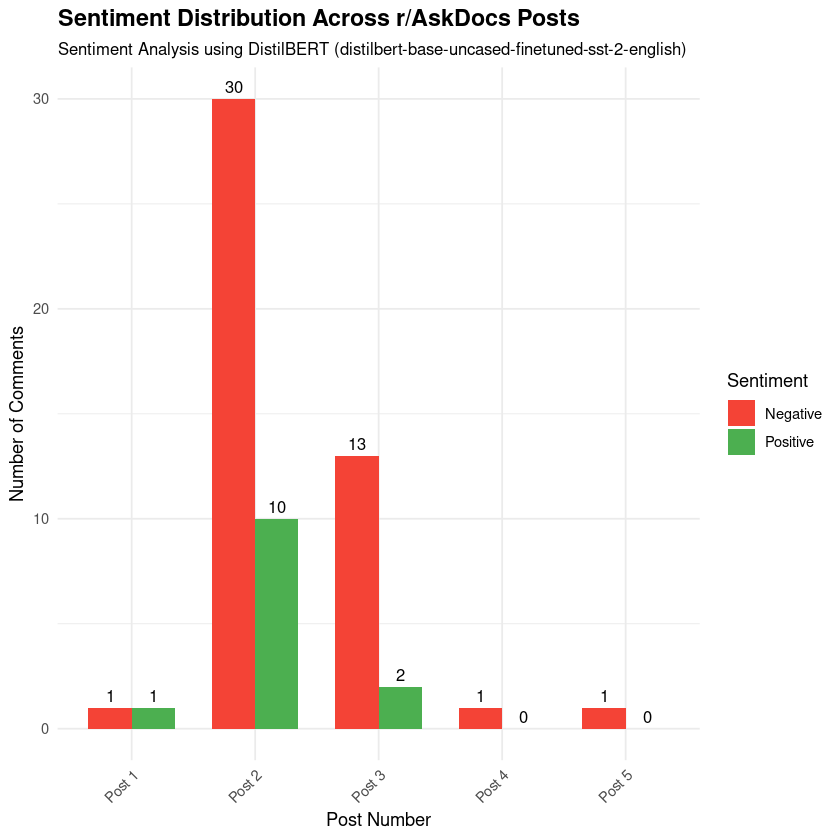

In [6]:
library(reticulate)
library(ggplot2)

cat("TASK 2: SENTIMENT ANALYSIS OF COMMENTS\n")


cat("Step 1: Importing Python transformers library...\n")
transformers <- import("transformers")
torch <- import("torch")
cat(sprintf("Successfully imported transformers version: %s\n", transformers$`__version__`))
cat(sprintf("Successfully imported torch version: %s\n\n", torch$`__version__`))

cat("Step 2: Creating DistilBERT sentiment analysis pipeline...\n")
cat("Model: distilbert-base-uncased-finetuned-sst-2-english\n")
sentiment_pipeline <- transformers$pipeline(
  "sentiment-analysis",
  model = "distilbert-base-uncased-finetuned-sst-2-english"
)
cat("Pipeline created successfully!\n\n")

cat("Step 3: Analyzing sentiment for comments from each of the 5 posts...\n\n")

all_sentiments <- list()
post_sentiment_summary <- data.frame()

for (i in 1:length(all_post_titles)) {
  cat(sprintf("-----------------------------------------------\n"))
  cat(sprintf("POST %d of %d\n", i, length(all_post_titles)))
  cat(sprintf("-----------------------------------------------\n"))
  cat(sprintf("Title: %s\n", all_post_titles[i]))
  cat(sprintf("URL: %s\n", all_post_urls[i]))

  comments <- all_comments[[i]]
  cat(sprintf("Total comments: %d\n\n", length(comments)))

  if (length(comments) > 0) {
    sentiments <- list()

    cat("Analyzing sentiment for each comment:\n")
    for (j in 1:length(comments)) {
      comment_preview <- substr(comments[j], 1, 80)

      result <- sentiment_pipeline(comments[j], truncation = TRUE, max_length = 512L)

      sentiments[[j]] <- list(
        comment_num = j,
        label = result[[1]]$label,
        score = result[[1]]$score
      )

      cat(sprintf("  Comment %d: %s (confidence: %.4f)\n",
                  j, result[[1]]$label, result[[1]]$score))
    }

    all_sentiments[[i]] <- sentiments

    positive_count <- sum(sapply(sentiments, function(x) x$label == "POSITIVE"))
    negative_count <- sum(sapply(sentiments, function(x) x$label == "NEGATIVE"))

    cat(sprintf("\nPost %d Sentiment Summary:\n", i))
    cat(sprintf("  Positive comments: %d (%.1f%%)\n",
                positive_count, positive_count/length(comments)*100))
    cat(sprintf("  Negative comments: %d (%.1f%%)\n\n",
                negative_count, negative_count/length(comments)*100))

    post_sentiment_summary <- rbind(post_sentiment_summary, data.frame(
      post_num = i,
      post_title = substr(all_post_titles[i], 1, 60),
      total_comments = length(comments),
      positive = positive_count,
      negative = negative_count,
      positive_pct = round(positive_count / length(comments) * 100, 1),
      negative_pct = round(negative_count / length(comments) * 100, 1)
    ))

  } else {
    cat("No comments to analyze for this post.\n\n")
  }
}

cat("STEP 4: SENTIMENT SUMMARY ACROSS ALL POSTS\n")

print(post_sentiment_summary)

cat("\n\nOverall Statistics:\n")
cat(sprintf("Total posts analyzed: %d\n", nrow(post_sentiment_summary)))
cat(sprintf("Total comments analyzed: %d\n", sum(post_sentiment_summary$total_comments)))
cat(sprintf("Total positive comments: %d\n", sum(post_sentiment_summary$positive)))
cat(sprintf("Total negative comments: %d\n", sum(post_sentiment_summary$negative)))
cat(sprintf("Overall positive percentage: %.1f%%\n",
            sum(post_sentiment_summary$positive)/sum(post_sentiment_summary$total_comments)*100))
cat(sprintf("Overall negative percentage: %.1f%%\n\n",
            sum(post_sentiment_summary$negative)/sum(post_sentiment_summary$total_comments)*100))

cat("STEP 5: VISUALIZING SENTIMENT DISTRIBUTION\n")


sentiment_long <- data.frame(
  post = rep(paste0("Post ", 1:nrow(post_sentiment_summary)), 2),
  sentiment = rep(c("Positive", "Negative"), each = nrow(post_sentiment_summary)),
  count = c(post_sentiment_summary$positive, post_sentiment_summary$negative)
)

sentiment_long$post <- factor(sentiment_long$post,
                               levels = paste0("Post ", 1:nrow(post_sentiment_summary)))

p <- ggplot(sentiment_long, aes(x = post, y = count, fill = sentiment)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  geom_text(aes(label = count), position = position_dodge(width = 0.7),
            vjust = -0.5, size = 3.5) +
  labs(
    title = "Sentiment Distribution Across r/AskDocs Posts",
    subtitle = "Sentiment Analysis using DistilBERT (distilbert-base-uncased-finetuned-sst-2-english)",
    x = "Post Number",
    y = "Number of Comments",
    fill = "Sentiment"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 10),
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) +
  scale_fill_manual(values = c("Positive" = "#4CAF50", "Negative" = "#F44336"))

print(p)

In [10]:
library(reticulate)

cat("TASK 3: BIOMEDICAL NAMED ENTITY RECOGNITION\n")

cat("Step 1: Creating Biomedical NER pipeline...\n")
cat("Model: d4data/biomedical-ner-all\n")

transformers <- import("transformers")

ner_pipeline <- transformers$pipeline(
  "ner",
  model = "d4data/biomedical-ner-all",
  aggregation_strategy = "simple"
)

cat("NER pipeline created successfully!\n\n")

cat("Step 2: Extracting biomedical entities from post titles and bodies...\n\n")

all_entities <- data.frame()

for (i in 1:length(all_post_titles)) {
  cat(sprintf("-----------------------------------------------\n"))
  cat(sprintf("POST %d of %d\n", i, length(all_post_titles)))
  cat(sprintf("-----------------------------------------------\n"))
  cat(sprintf("Title: %s\n\n", all_post_titles[i]))
  
  text_to_analyze <- paste(all_post_titles[i], all_post_bodies[i], sep = " ")
  
  cat("Analyzing post title and body for biomedical entities...\n")
  
  entities <- ner_pipeline(text_to_analyze)
  
  if (length(entities) > 0) {
    cat(sprintf("Found %d entities:\n\n", length(entities)))
    
    for (j in 1:length(entities)) {
      entity <- entities[[j]]
      
      cat(sprintf("  Entity %d:\n", j))
      cat(sprintf("    Text: %s\n", entity$word))
      cat(sprintf("    Type: %s\n", entity$entity_group))
      cat(sprintf("    Confidence: %.4f\n\n", entity$score))
      
      all_entities <- rbind(all_entities, data.frame(
        post_num = i,
        post_title = substr(all_post_titles[i], 1, 50),
        entity_text = entity$word,
        entity_type = entity$entity_group,
        confidence = round(entity$score, 4),
        stringsAsFactors = FALSE
      ))
    }
  } else {
    cat("No biomedical entities found.\n\n")
  }
}

# Clean up tokenization artifacts (## symbols)
all_entities$entity_text <- gsub("##", "", all_entities$entity_text)

cat("SUMMARY TABLE OF ALL EXTRACTED ENTITIES\n")
print(all_entities)

cat("\n\nEntity Type Distribution:\n")
entity_counts <- table(all_entities$entity_type)
print(entity_counts)

cat("\n\nEntities by Post:\n")
entities_by_post <- table(all_entities$post_num)
print(entities_by_post)

cat(sprintf(" Total entities extracted: %d\n", nrow(all_entities)))

TASK 3: BIOMEDICAL NAMED ENTITY RECOGNITION
Step 1: Creating Biomedical NER pipeline...
Model: d4data/biomedical-ner-all
NER pipeline created successfully!

Step 2: Extracting biomedical entities from post titles and bodies...

-----------------------------------------------
POST 1 of 5
-----------------------------------------------
Title: UPDATE: I (23F) was attacked in a DV situation and I got pretty bad black eyes. They've mostly healed but now my perfect vision seems to be going downhill

Analyzing post title and body for biomedical entities...
Found 21 entities:

  Entity 1:
    Text: d
    Type: Disease_disorder
    Confidence: 0.9639

  Entity 2:
    Text: ##v
    Type: History
    Confidence: 0.4738

  Entity 3:
    Text: mostly healed
    Type: Detailed_description
    Confidence: 0.9965

  Entity 4:
    Text: perfect vision
    Type: Sign_symptom
    Confidence: 0.9921

  Entity 5:
    Text: go
    Type: Clinical_event
    Confidence: 0.8587

  Entity 6:
    Text: hospital
 